In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from ggplot import *
from matplotlib import gridspec
import os
os.chdir('/home/bojk/Data') #this is when opened in '/home/bojk/Data/notebooks' on linux Quakelab
import sys
sys.path.append('/home/bojk/Data/minimeta_pyfiles/')
import imp
import minimetagenome_analysis as minimeta
#imp.reload(minimeta)

In [54]:
#import ggplot
%pwd

'/home/bojk/Data'

In [37]:
count_table = pd.read_csv('PAIN/count_table.csv').set_index('Unnamed: 0')
count_table.head()

,DB042_J11,DB042_D18,DB042_C14,DB042_D17,DB042_I13,DB042_J17,DB042_G11,DB042_D11,DB042_B19,DB042_M20,...,DB042_E14,DB042_H16,DB042_F9,DB042_I20,DB042_N3,DB042_N12,DB042_D4,DB042_B23,DB042_I4,DB042_L3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
-343C11.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00R_AC107638.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00R_Pgap2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
top = count_table[count_table.sum(axis=1)>1e5]

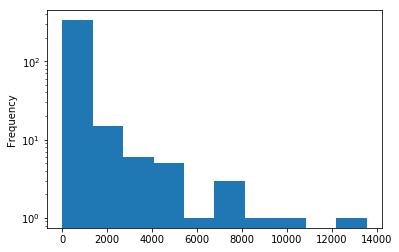

In [39]:
top.iloc[10,:].plot.hist(log=True)
plt.show()

In [40]:
# dataframe structure
top.head()

,DB042_J11,DB042_D18,DB042_C14,DB042_D17,DB042_I13,DB042_J17,DB042_G11,DB042_D11,DB042_B19,DB042_M20,...,DB042_E14,DB042_H16,DB042_F9,DB042_I20,DB042_N3,DB042_N12,DB042_D4,DB042_B23,DB042_I4,DB042_L3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Aldoc,0,0,0,0,0,0,0,7,0,0,...,1069,0,0,0,21,0,1,0,36,0
Apoe,0,0,1865,0,0,0,0,0,0,0,...,19,0,0,0,520,0,1,0,998,0
Cst3,0,0,0,0,0,0,0,0,0,782,...,0,0,0,0,0,0,0,0,0,0
Eef1a1,5,0,1840,0,0,0,0,0,0,0,...,0,0,0,0,764,0,0,0,435,0
Fth1,11351,0,25053,0,0,0,0,2430,0,1,...,30261,0,0,0,2851,0,0,0,4192,0


In [9]:
df = pd.melt(top.T) #make into a catagorical dataframe
ggplot(aes(x='value',color='Unnamed: 0'),data=df) + geom_density() 

NameError: name 'ggplot' is not defined

In [41]:
dflog = pd.melt(top.T +1)
dflog['log2'] = np.log2(dflog['value'])

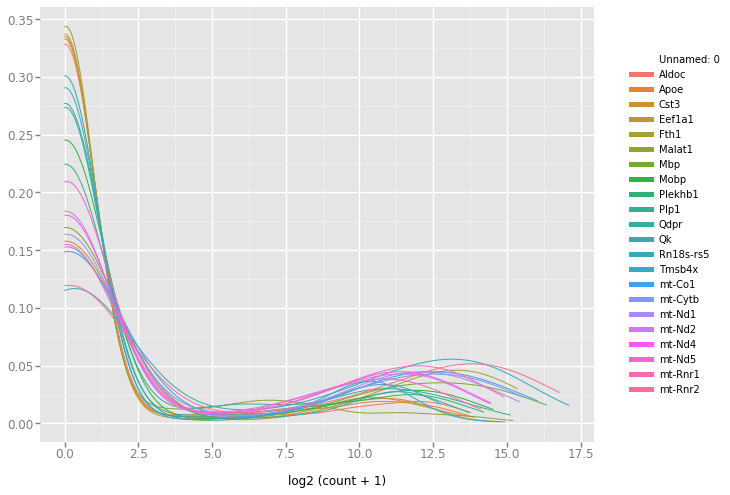

<ggplot: (-9223372029266984567)>

In [185]:
G=  ggplot(aes(x='log2',color='Unnamed: 0'),data=dflog) + geom_density() \
    + xlab('log2 (count + 1)')
G

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


LinAlgError: singular matrix

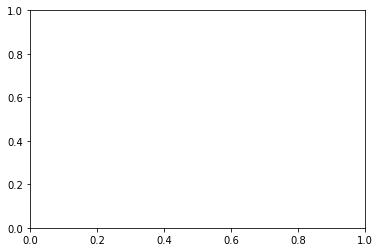

In [55]:
# let's see if kdeplot can do the same, probably easier to extract the density profiles for 
# future fitting purposes
logdf2 = np.log2(top.T +1)
al = sns.kdeplot(logdf2.T,bw=1) # this results in the combined density of the dataframe
plt.show()


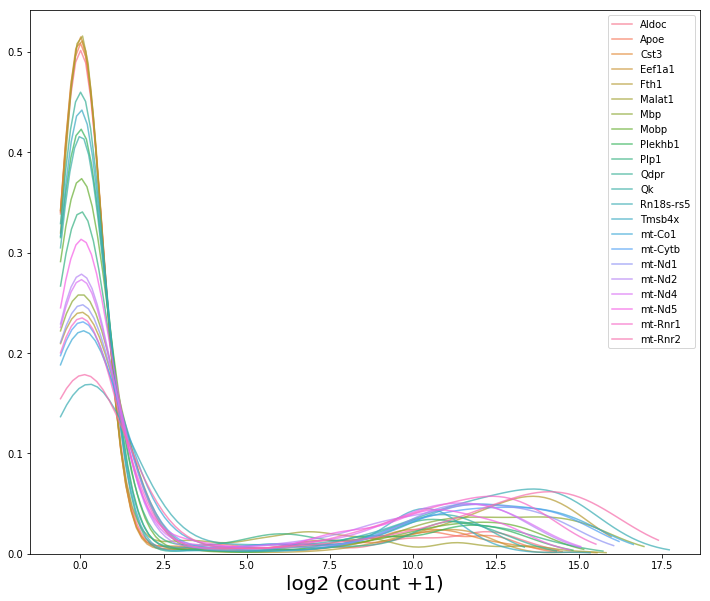

In [56]:
logdf2 = np.log2(top +1)
values = sns.color_palette('husl',len(logdf2.index))
keys = list(logdf2.index)
coldict = dict(zip(keys,values))

f = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
for gene in logdf2.index:
    sns.kdeplot(logdf2.loc[gene,:],bw=.2,ax=ax1,color=coldict[gene], alpha=.7)
plt.xlabel('log2 (count +1)',fontsize=20)
f.set_figheight(10)
f.set_figwidth(12)
plt.show()

 This seems reasonably similar (though ggplot is esthetically more pleasing), yet not sure
 this is exactly the same though. The probability (y-axis, or pdf?) is not the same. This
 remains to be seen. However, I can try and extract the density profiles such that I can fit
 them individually. 

In [51]:
import statsmodels.api as sm

def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = sm.nonparametric.KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = sm.nonparametric.KDEMultivariate(x, bw=bandwidth * np.ones_like(xwhci
                                                                         ),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)

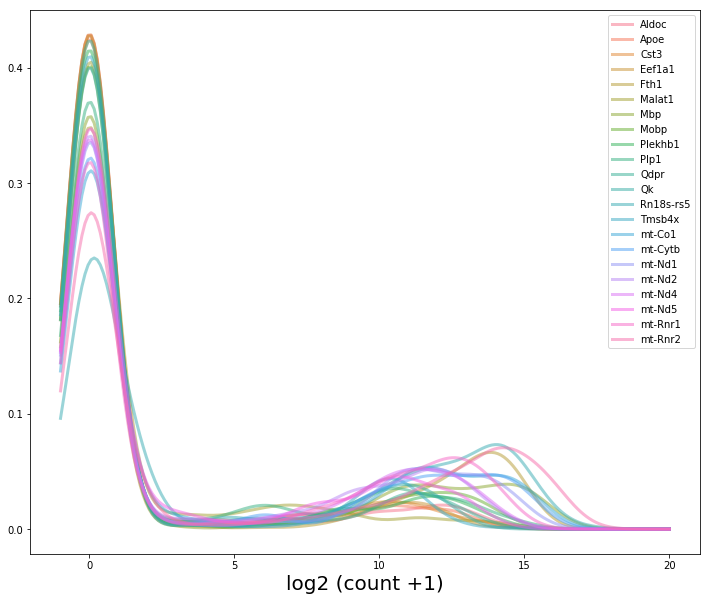

In [57]:
# let's use the statsmodels nonparametric KDE functions, as these automatically output the 
# desired density curve.

x_grid = np.linspace(-1,20,200)
pdf_df = pd.DataFrame(index=x_grid,columns=keys) # generates pdf dataframe

f = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

for gene in logdf2.index:
    x = logdf2.loc[gene,:]
    pdf = kde_statsmodels_u(x,x_grid,bandwidth=.8)
    ax1.plot(x_grid, pdf, color=coldict[gene], alpha=0.5, lw=3)
    pdf_df[gene] = pdf # write to dataframe
plt.xlabel('log2 (count +1)',fontsize=20)
plt.legend(logdf2.index)
f.set_figheight(10)
f.set_figwidth(12)
plt.show()

In [58]:
pdf_df.head()

,Aldoc,Apoe,Cst3,Eef1a1,Fth1,Malat1,Mbp,Mobp,Plekhb1,Plp1,...,Rn18s-rs5,Tmsb4x,mt-Co1,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd4,mt-Nd5,mt-Rnr1,mt-Rnr2
-1.000000,0.195617,0.193756,0.195668,0.195556,0.158001,0.181514,0.162345,0.182198,0.189413,0.167936,...,0.096067,0.185979,0.137099,0.144111,0.150855,0.154301,0.153008,0.155350,0.144257,0.119849
-0.894472,0.228725,0.226549,0.228795,0.228641,0.184798,0.212406,0.189877,0.213085,0.221472,0.196414,...,0.112824,0.217518,0.160538,0.168642,0.176506,0.180480,0.178958,0.181799,0.168713,0.140398
-0.788945,0.262833,0.260333,0.262925,0.262719,0.212429,0.244311,0.218265,0.244927,0.254500,0.225779,...,0.130329,0.250037,0.184797,0.193981,0.202987,0.207480,0.205718,0.209120,0.193928,0.161694
-0.683417,0.296829,0.294007,0.296949,0.296676,0.240003,0.276219,0.246593,0.276696,0.287421,0.255082,...,0.148100,0.282487,0.209127,0.219325,0.229456,0.234432,0.232426,0.236453,0.219088,0.183090
-0.577889,0.329456,0.326325,0.329609,0.329255,0.266510,0.306984,0.273825,0.307224,0.319017,0.283251,...,0.165588,0.313679,0.232677,0.243767,0.254955,0.260354,0.258106,0.262819,0.243271,0.203849


ok, so now we have the pdf dataframe, to which we can fit gaussians. However, this might 
be doing the same work twice, as the KDE algorithm already uses a mixture of gaussians
In addition, the bandwidth is always the same and has some relationship with the number 
of gaussians used, yet this has not been cross-validated. Scikit learn has a cross validation
package for this we can use 

end goal: we want to have an optimal number of gaussians and their attibutes mean, sigma, amplitude as output for each gene expression profile. So perhaps we need to look further at
other packages, as gaussian mixture models are a very established concept.

In [59]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

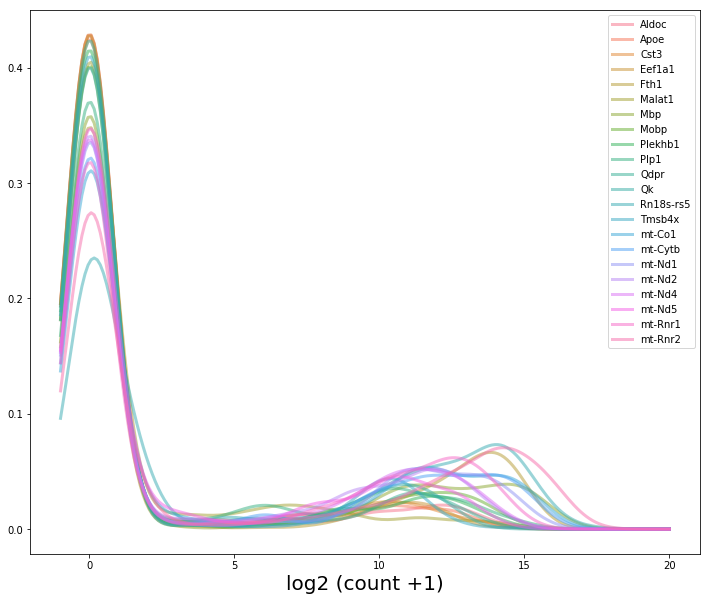

In [60]:
x_grid = np.linspace(-1,20,200)
pdf_df_skl = pd.DataFrame(index=x_grid,columns=keys) # generates pdf dataframe

f = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

for gene in logdf2.index:
    x = logdf2.loc[gene,:]
    pdf = kde_sklearn(x,x_grid,bandwidth=.8)
    ax1.plot(x_grid, pdf, color=coldict[gene], alpha=0.5, lw=3)
    pdf_df_skl[gene] = pdf # write to dataframe
plt.xlabel('log2 (count +1)',fontsize=20)
plt.legend(logdf2.index)
f.set_figheight(10)
f.set_figwidth(12)
plt.show()

In [61]:
pdf_df_skl.head()

,Aldoc,Apoe,Cst3,Eef1a1,Fth1,Malat1,Mbp,Mobp,Plekhb1,Plp1,...,Rn18s-rs5,Tmsb4x,mt-Co1,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd4,mt-Nd5,mt-Rnr1,mt-Rnr2
-1.000000,0.195617,0.193756,0.195668,0.195556,0.158001,0.181514,0.162345,0.182198,0.189413,0.167936,...,0.096067,0.185979,0.137099,0.144111,0.150855,0.154301,0.153008,0.155350,0.144257,0.119849
-0.894472,0.228725,0.226549,0.228795,0.228641,0.184798,0.212406,0.189877,0.213085,0.221472,0.196414,...,0.112824,0.217518,0.160538,0.168642,0.176506,0.180480,0.178958,0.181799,0.168713,0.140398
-0.788945,0.262833,0.260333,0.262925,0.262719,0.212429,0.244311,0.218265,0.244927,0.254500,0.225779,...,0.130329,0.250037,0.184797,0.193981,0.202987,0.207480,0.205718,0.209120,0.193928,0.161694
-0.683417,0.296829,0.294007,0.296949,0.296676,0.240003,0.276219,0.246593,0.276696,0.287421,0.255082,...,0.148100,0.282487,0.209127,0.219325,0.229456,0.234432,0.232426,0.236453,0.219088,0.183090
-0.577889,0.329456,0.326325,0.329609,0.329255,0.266510,0.306984,0.273825,0.307224,0.319017,0.283251,...,0.165588,0.313679,0.232677,0.243767,0.254955,0.260354,0.258106,0.262819,0.243271,0.203849


exactly the same results.

In [62]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

ModuleNotFoundError: No module named 'sklearn.grid_search'

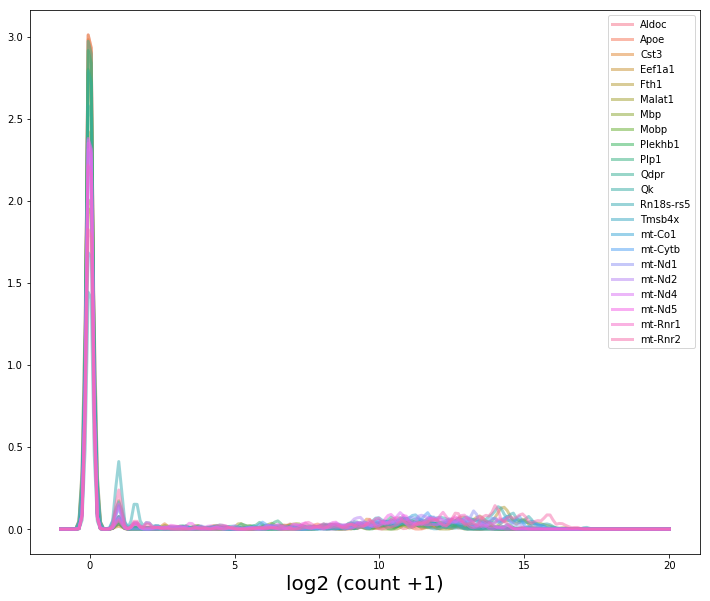

In [212]:
x_grid = np.linspace(-1,20,200)
pdf_df_skl_CV = pd.DataFrame(index=x_grid,columns=keys) # generates pdf dataframe

f = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

for gene in logdf2.index:
    x = logdf2.loc[gene,:]
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
    grid.fit(x[:, None])
    bw = grid.best_params_['bandwidth'] #get cross-validated bandwidth
    pdf = kde_sklearn(x,x_grid,bandwidth=bw)
    ax1.plot(x_grid, pdf, color=coldict[gene], alpha=0.5, lw=3)
    pdf_df_skl_CV[gene] = pdf # write to dataframe
plt.xlabel('log2 (count +1)',fontsize=20)
plt.legend(logdf2.index)
f.set_figheight(10)
f.set_figwidth(12)
plt.show()

hmmm, this doesn't seem to produce great results. I have the feeling this might be a result
of the low power (~300 cells) and the fact that most have zero expression for a given gene.
To be continued...

Back to the gaussians then.

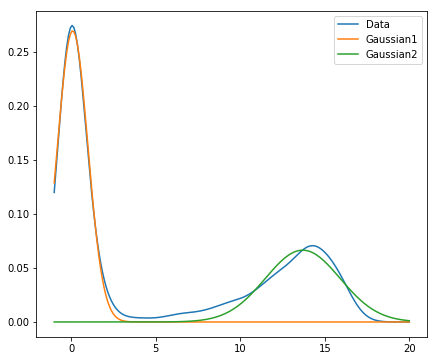

In [63]:
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def gauss2(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2 = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))



y_data = pdf_df_skl[gene]
X_data = x_grid
# p0 is the initial guess for the fitting coefficients 
# initialize them differently so the optimization algorithm works better
p0 = [.3, 0, 1.,.1, 10, 1.]

#optimize and in the end you will have 6 coeff (3 for each gaussian)
coeff, var_matrix = curve_fit(gauss2, X_data, y_data, p0=p0)

#you can plot each gaussian separately using 
pg1 = coeff[0:3]
pg2 = coeff[3:]

g1 = gauss(X_data, *pg1)
g2 = gauss(X_data, *pg2)

f = plt.figure()
f.set_figheight(6)
f.set_figwidth(7)
plt.plot(X_data, y_data, label='Data')
plt.plot(X_data, g1, label='Gaussian1')
plt.plot(X_data, g2, label='Gaussian2')
plt.legend()
plt.show()

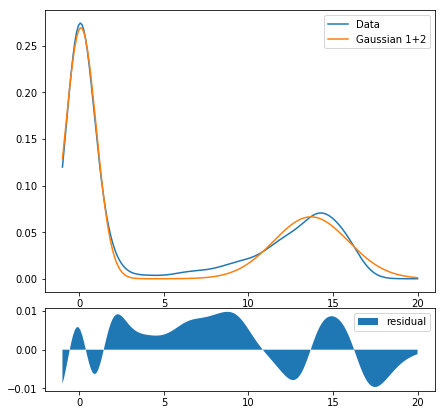

In [64]:
f = plt.figure()
f.set_figheight(7)
f.set_figwidth(7)
gs = gridspec.GridSpec(4,1)
ax1 = f.add_subplot(gs[0:3,0])
ax1.plot(X_data, y_data, label='Data')
ax1.plot(X_data, g1+g2, label='Gaussian 1+2')
plt.legend()
ax2 = f.add_subplot(gs[3,0])
ax2.fill_between(X_data,0,y_data-(g1+g2),label='residual')
plt.legend()
plt.show()

That works reasonably well, but let's try 3 or 4 gaussians before continuing.

In [65]:
def gauss3(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3 = p
    return(A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2)) \
        + A3*np.exp(-(x-mu3)**2/(2.*sigma3**2)))

def gauss4(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, A4, mu4, sigma4 = p
    return(A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2)) \
        + A3*np.exp(-(x-mu3)**2/(2.*sigma3**2)) + A4*np.exp(-(x-mu4)**2/(2.*sigma4**2)))

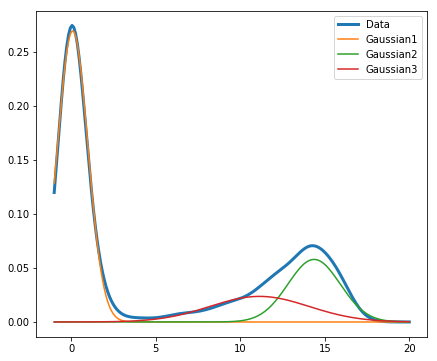

In [66]:
# p0 is the initial guess for the fitting coefficients 
p0 = [.3, 0, 1.,.1, 14, 1.,.03,10,1.]

#optimize and in the end you will have 6 coeff (3 for each gaussian)
coeff, var_matrix = curve_fit(gauss3, X_data, y_data, p0=p0)

#you can plot each gaussian separately using 
pg1 = coeff[0:3]
pg2 = coeff[3:6]
pg3 = coeff[6:]

g1 = gauss(X_data, *pg1)
g2 = gauss(X_data, *pg2)
g3 = gauss(X_data, *pg3)

f = plt.figure()
f.set_figheight(6)
f.set_figwidth(7)
plt.plot(X_data, y_data, label='Data',lw=3)
plt.plot(X_data, g1, label='Gaussian1')
plt.plot(X_data, g2, label='Gaussian2')
plt.plot(X_data, g3, label='Gaussian3')
plt.legend()
plt.show()

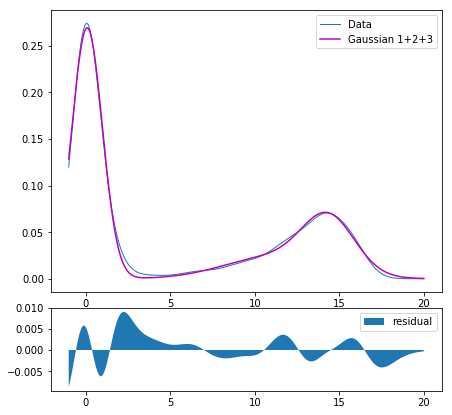

In [67]:
f = plt.figure()
gs = gridspec.GridSpec(4,1)

ax1 = f.add_subplot(gs[0:3,0])
ax1.plot(X_data, y_data, label='Data',lw=1)
ax1.plot(X_data, g1+g2+g3, label='Gaussian 1+2+3',c='m')
plt.legend()
ax2 = f.add_subplot(gs[3,0])
ax2.fill_between(X_data,0,y_data-(g1+g2+g3),label='residual')
plt.legend()

f.set_figheight(7)
f.set_figwidth(7)
plt.show()

Obviously, a 3-gaussian fit works better than a 2, but simplicity of the model is key if
we are to figure out the broad strokes. We'll have to get a feel of the data to see how 
many gaussians are optimal. 

In [72]:
abs(X_data[-1]-X_data[0])

21.0

In [111]:
from simanneal import Annealer
from lmfit import minimize, Parameters
"""
pipeline: 
    try one gauss
    if residual < preset_value
    end
    else try two gauss
    simulated annealing
    if residual < preset_value
    end
    else try three gauss
    simulated annealing
    #if residual < preset_value
    end
"""


# Double Gaussian   (labeled below as ..._2g)

def fit_double_gauss(x,y):
    p_2g=Parameters()
    p_2g.add('amp1',value=np.max(y)/2.,min=.1*np.max(y),max=np.max(y));
    p_2g.add('center1',value=0,min=np.min(x),max=np.max(x));
    p_2g.add('sig1',value=2*abs(x[1]-x[0]),min=abs(x[1]-x[0]),max=abs(x[-1]-x[0]));
    p_2g.add('amp2',value=np.max(y)/2.,min=.1*np.max(y),max=np.max(y));
    p_2g.add('center2',value=x[-30],min=np.min(x),max=np.max(x));
    p_2g.add('sig2',value=3*abs(x[1]-x[0]),min=abs(x[1]-x[0]),max=abs(x[-1]-x[0]));

    gausserr_2g = lambda p,x0,y0: gaussfunc_2g(p,x0)-y0
    gausssingle = lambda a,c,sig,x0: a*np.exp(-.5*((x0-c)/sig)**2)
    fitout_2g=minimize(gausserr_2g,p_2g,args=(x,y))
    fitted_p_2g = fitout_2g.params
    pars_2g=[fitted_p_2g['amp1'].value,
         fitted_p_2g['center1'].value,
         fitted_p_2g['sig1'].value,
         fitted_p_2g['amp2'].value,
         fitted_p_2g['center2'].value,
         fitted_p_2g['sig2'].value]

    fit_2g=gaussfunc_2g(fitted_p_2g,x)
    resid_2g=fit_2g-y
    print('Fitted Parameters (Double Gaussian):\nAmp1 = %.2f , Center1 = %.2f , Sig1 = %.2f\nAmp2 = %.2f , Center2 = %.2f , Sig2 = %.2f' \
    %(pars_2g[0],pars_2g[1],pars_2g[2],pars_2g[3],pars_2g[4],pars_2g[5]))

    return pars_2g,fit_2g,resid_2g

    
def gaussfunc_2g(paramsin,x):
    amp1=paramsin['amp1'].value;
    amp2=paramsin['amp2'].value;
    center1=paramsin['center1'].value;
    center2=paramsin['center2'].value;
    sig1=paramsin['sig1'].value;
    sig2=paramsin['sig2'].value;
    g1=(x-center1)/sig1
    g2=(x-center2)/sig2

    gaus1=amp1*np.exp(-.5*g1**2)
    gaus2=amp2*np.exp(-.5*g2**2)
    gaustot_2g=(gaus1+gaus2)
    return gaustot_2g

def gaussfunc_3g(paramsin,x):
    amp1=paramsin['amp1'].value;
    amp2=paramsin['amp2'].value;
    amp3=paramsin['amp3'].value;
    center1=paramsin['center1'].value;
    center2=paramsin['center2'].value;
    center3=paramsin['center3'].value;
    sig1=paramsin['sig1'].value;
    sig2=paramsin['sig2'].value;
    sig3=paramsin['sig3'].value;
    g1=(x-center1)/sig1
    g2=(x-center2)/sig2
    g3=(x-center3)/sig3
    gaus1=amp1*np.exp(-.5*g1**2)
    gaus2=amp2*np.exp(-.5*g2**2)
    gaus3=amp3*np.exp(-.5*g3**2)
    gaustot_3g=(gaus1+gaus2+gaus3)
    return gaustot_3g

def fit_triple_gauss(x,y):
    p_3g=Parameters()
    p_3g.add('amp1',value=np.max(y)/2.,min=.1*np.max(y),max=np.max(y));
    p_3g.add('center1',value=0,min=np.min(x),max=np.max(x));
    p_3g.add('sig1',value=2*abs(x[1]-x[0]),min=abs(x[1]-x[0]),max=abs(x[-1]-x[0]));
    p_3g.add('amp2',value=np.max(y)/2.,min=.1*np.max(y),max=np.max(y));
    p_3g.add('center2',value=x[-30],min=5,max=np.max(x));
    p_3g.add('sig2',value=3*abs(x[1]-x[0]),min=2,max=abs(x[-1]-x[0])/2);
    p_3g.add('amp3',value=np.max(y)/2.,min=.1*np.max(y),max=np.max(y));
    p_3g.add('center3',value=x[-30],min=5,max=np.max(x));
    p_3g.add('sig3',value=3*abs(x[1]-x[0]),min=2,max=abs(x[-1]-x[0])/2);

    gausserr_3g = lambda p,x0,y0: gaussfunc_3g(p,x0)-y0
    gausssingle = lambda a,c,sig,x0: a*np.exp(-.5*((x0-c)/sig)**2)
    fitout_3g=minimize(gausserr_3g,p_3g,args=(x,y))
    fitted_p_3g = fitout_3g.params
    pars_3g=[fitted_p_3g['amp1'].value,
         fitted_p_3g['center1'].value,
         fitted_p_3g['sig1'].value,
         fitted_p_3g['amp2'].value,
         fitted_p_3g['center2'].value,
         fitted_p_3g['sig2'].value,
         fitted_p_3g['amp3'].value,
         fitted_p_3g['center3'].value,
         fitted_p_3g['sig3'].value]

    fit_3g = gaussfunc_3g(fitted_p_3g,x)
    resid_3g = fit_3g-y
    print('Fitted Parameters (Triple Gaussian):\nAmp1 = %.2f , Center1 = %.2f , Sig1 = %.2f\nAmp2 = %.2f , Center2 = %.2f , Sig2 = %.2f\nAmp3 = %.2f , Center3 = %.2f , Sig3 = %.2f' \
    %(pars_3g[0],pars_3g[1],pars_3g[2],pars_3g[3],pars_3g[4],pars_3g[5],pars_3g[6],pars_3g[7],pars_3g[8]))
    return pars_3g,fit_3g,resid_3g

a,b,c = fit_triple_gauss(X_data,y_data)

d,e,f = fit_double_gauss(X_data,y_data)




Fitted Parameters (Triple Gaussian):
Amp1 = 0.26 , Center1 = 0.08 , Sig1 = 0.84
Amp2 = 0.18 , Center2 = 14.12 , Sig2 = 9.77
Amp3 = 0.03 , Center3 = 6.16 , Sig3 = 6.65
Fitted Parameters (Double Gaussian):
Amp1 = 0.27 , Center1 = 0.09 , Sig1 = 0.90
Amp2 = 0.07 , Center2 = 13.70 , Sig2 = 2.21


-0.3543212382805454
27.50610868393956


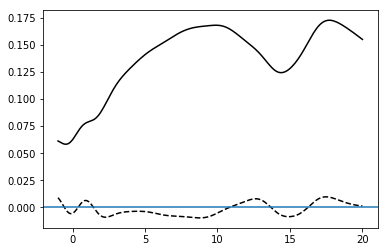

In [112]:
#plt.fill_between(resid_2g[0],resid_2g[1])
plt.plot(X_data,resid_2g,'k--',X_data,c,'k')
plt.axhline(0)
print(sum(resid_2g))
print(sum(c))

In [113]:
a

[0.2552131876870072,
 0.08186103967113789,
 0.836882661394766,
 0.18206167068891613,
 14.11640338127622,
 9.77186796320128,
 0.02750876463266222,
 6.158590710002223,
 6.6485886938157455]

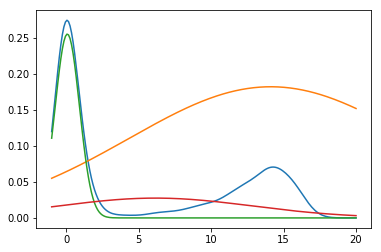

In [114]:
gausssingle = lambda a,c,sig,x0: a*np.exp(-.5*((x0-c)/sig)**2)
plt.plot(X_data,y_data)
plt.plot(X_data,gausssingle(a[3],a[4],a[5],X_data))
plt.plot(X_data,gausssingle(a[0],a[1],a[2],X_data))
plt.plot(X_data,gausssingle(a[6],a[7],a[8],X_data))

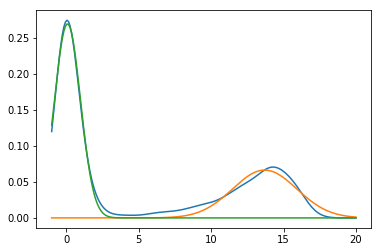

In [102]:
plt.plot(X_data,y_data)
plt.plot(X_data,gausssingle(d[3],d[4],d[5],X_data))
plt.plot(X_data,gausssingle(d[0],d[1],d[2],X_data))

In [116]:
x0 = np.array([2., 2.])     # Initial guess.
from scipy import optimize
np.random.seed(555)   # Seeded to allow replication.
res = optimize.anneal(f, x0, args=params, schedule='boltzmann',
                          full_output=True, maxiter=500, lower=-10,
                          upper=10, dwell=250, disp=True)
res[0]  # obtained minimum

res[1]  # function value at minimum


AttributeError: module 'scipy.optimize' has no attribute 'anneal'

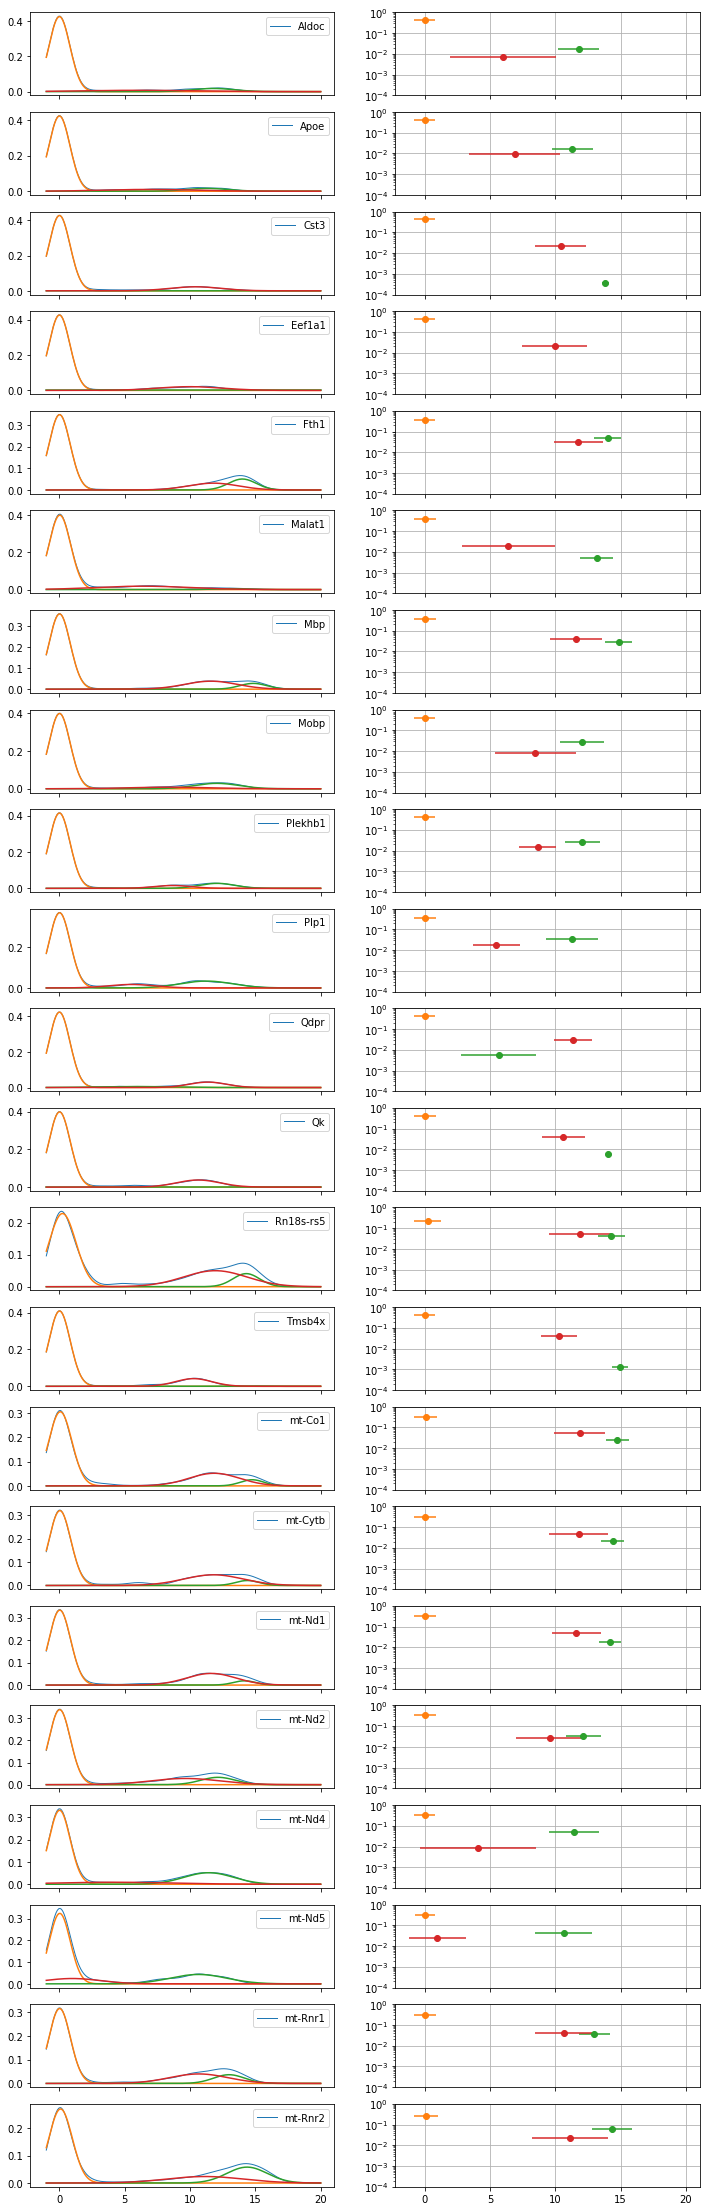

In [20]:
# let's get the parameters for the top dataset
p0 = [.3, 0, 1.,.1, 14, 1.,.03,10,1.]
paramdf_3gauss = pd.DataFrame(index=pdf_df_skl.columns,columns=['a1','mu1','s1','a2','mu2','s2','a3','mu3','s3'])
X_data = x_grid

height = int(round(len(paramdf_3gauss)*1.8))
f, ax = plt.subplots(len(paramdf_3gauss),2, sharex=True,figsize=(12,height))
a=0
for gene in pdf_df_skl.columns:
    y_data = pdf_df_skl[gene]
    coeff, var_matrix = curve_fit(gauss3, X_data, y_data, p0=p0,bounds=(0,np.inf))
    paramdf_3gauss.loc[gene,:] = coeff
    
    pg1 = coeff[0:3];pg2 = coeff[3:6];pg3 = coeff[6:]
    g1 = gauss(X_data, *pg1); g2 = gauss(X_data, *pg2); g3 = gauss(X_data, *pg3)
    
    # lefthand plots
    ax[a][0].plot(X_data, y_data, label=gene,lw=1)
    ax[a][0].plot(X_data, g1, label=None)
    ax[a][0].plot(X_data, g2, label=None)
    ax[a][0].plot(X_data, g3, label=None)
    ax[a][0].legend()
    
    # parameter plots
    ax[a][1].errorbar(0,0,xerr=0)
    kwds = {'fmt':'o', 'capthick':2}
    ax[a][1].errorbar(pg1[1],pg1[0],xerr=pg1[2],**kwds)
    ax[a][1].errorbar(pg2[1],pg2[0],xerr=pg2[2],**kwds)
    ax[a][1].errorbar(pg3[1],pg3[0],xerr=pg3[2],**kwds)
    
    ax[a][1].set_yscale('log')
    ax[a][1].set_ylim(1e-4,1)
    ax[a][1].grid()
    
    a+=1
plt.show()
paramdf_3gauss = paramdf_3gauss.astype(float)

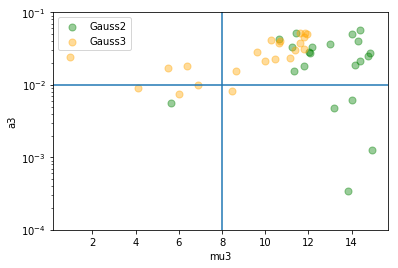

In [21]:
f  = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1= f.add_subplot(gs[0,0])
paramdf_3gauss.plot.scatter('mu2','a2',c='g',ax=ax1,label='Gauss2',s=50,alpha=.4)
paramdf_3gauss.plot.scatter('mu3','a3',c='orange',ax=ax1,label='Gauss3',s=50,alpha=.4)
plt.yscale('log')
plt.ylim(1e-4,.1)
plt.axhline(1e-2,0,20)
plt.axvline(8,1e-4,1)
plt.show()


let's sequentially fit one at 0, subtract and in an unbiased way do a 2-gauss fit on the others

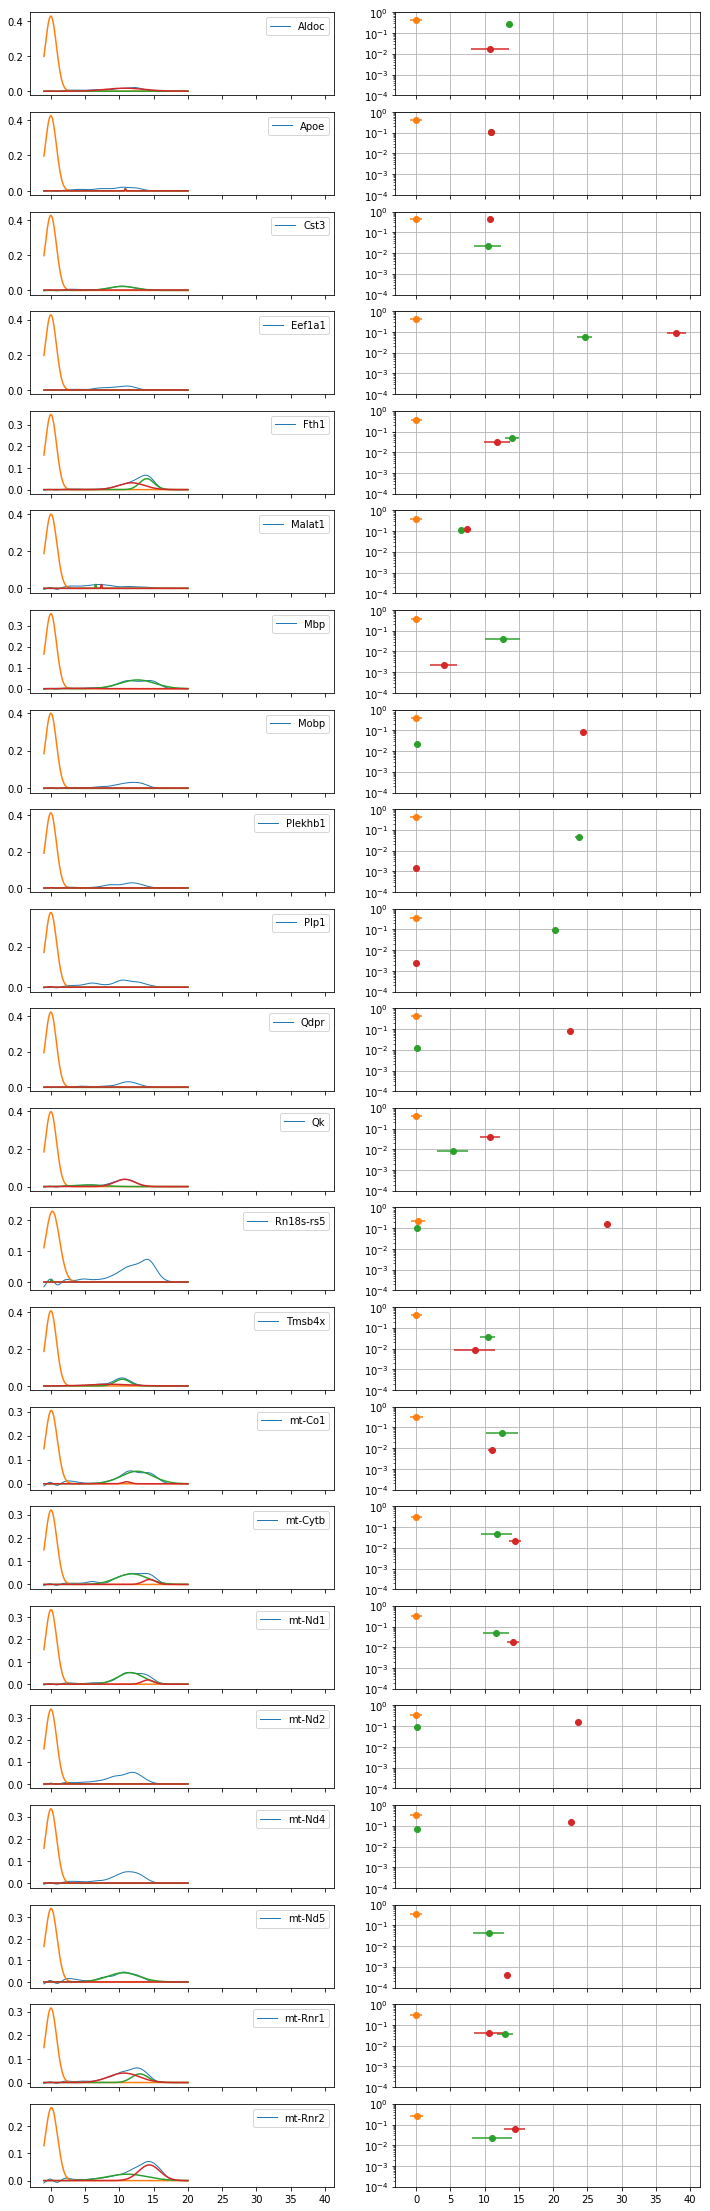

In [39]:
# let's get the parameters for the top dataset
p0 = [.3, 0, 1.,.1, 0, 1.,.03,0,1.]
paramdf_3gauss = pd.DataFrame(index=pdf_df_skl.columns,columns=['a1','mu1','s1','a2','mu2','s2','a3','mu3','s3'])
X_data = x_grid

height = int(round(len(paramdf_3gauss)*1.8))
f, ax = plt.subplots(len(paramdf_3gauss),2, sharex=True,figsize=(12,height))
a=0
for gene in pdf_df_skl.columns:
    y_data = pdf_df_skl[gene]
    coeff, var_matrix = curve_fit(gauss, X_data, y_data, p0=p0[0:3],bounds=(0,np.inf))
    paramdf_3gauss.loc[gene,0:3] = coeff
    pg1 = coeff[0:3]
    g1 = gauss(X_data, *pg1)
    y_data = pdf_df_skl[gene] - g1
    coeff, var_matrix = curve_fit(gauss2, X_data, y_data, p0=[.3,y_data[y_data==y_data.max()].index[0],max(y_data),.3,y_data[y_data==y_data.max()].index[0],max(y_data)],bounds=(0,np.inf))
    paramdf_3gauss.loc[gene,3:] = coeff
    pg2 = coeff[0:3];pg3 = coeff[3:]
    g2 = gauss(X_data, *pg2); g3 = gauss(X_data, *pg3)
    
    # lefthand plots
    ax[a][0].plot(X_data, y_data, label=gene,lw=1)
    ax[a][0].plot(X_data, g1, label=None)
    ax[a][0].plot(X_data, g2, label=None)
    ax[a][0].plot(X_data, g3, label=None)
    ax[a][0].legend()
    
    # parameter plots
    ax[a][1].errorbar(0,0,xerr=0)
    kwds = {'fmt':'o', 'capthick':2}
    ax[a][1].errorbar(pg1[1],pg1[0],xerr=pg1[2],**kwds)
    ax[a][1].errorbar(pg2[1],pg2[0],xerr=pg2[2],**kwds)
    ax[a][1].errorbar(pg3[1],pg3[0],xerr=pg3[2],**kwds)
    
    ax[a][1].set_yscale('log')
    ax[a][1].set_ylim(1e-4,1)
    ax[a][1].grid()
    
    a+=1
plt.show()
paramdf_3gauss = paramdf_3gauss.astype(float)

In [36]:
paramdf_3gauss
y_data
pdf_df_skl[gene]
y_data[y_data==y_data.max()].index[0]

12.190954773869347

OK, let's try this with more data.

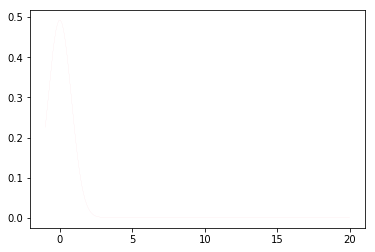

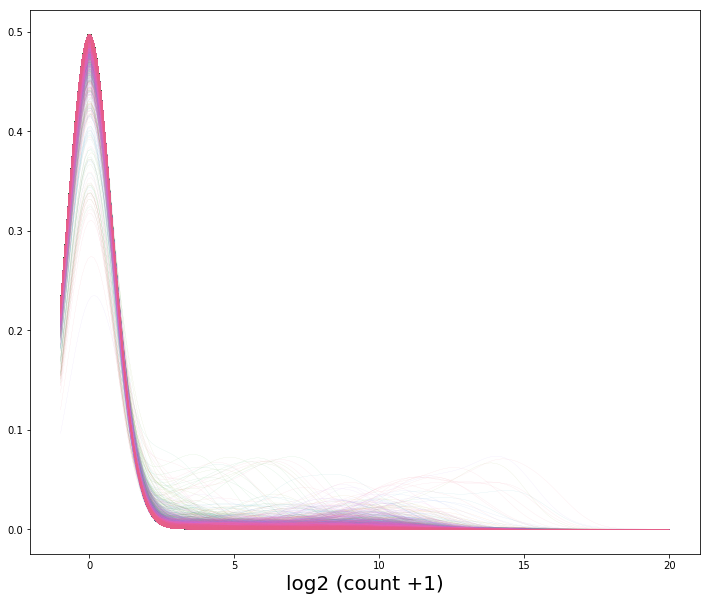

In [331]:
genes_with_expr = count_table[count_table.sum(axis=1)>0] # 17000 genes out of 50k
logalldf = np.log2(genes_with_expr +1)
values = sns.color_palette('husl',len(logalldf.index))
keys = list(logalldf.index)
coldict = dict(zip(keys,values))

x_grid = np.linspace(-1,20,200)
pdfall_df_skl = pd.DataFrame(index=x_grid,columns=keys) # generates pdf dataframe

f = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

for gene in logalldf.index:
    x = logalldf.loc[gene,:]
    pdf = kde_sklearn(x,x_grid,bandwidth=.8) # the pdf calculation
    ax1.plot(x_grid, pdf, color=coldict[gene], alpha=0.5, lw=.1)
    pdfall_df_skl[gene] = pdf # write to dataframe
plt.xlabel('log2 (count +1)',fontsize=20)
#plt.legend(logdf2.index)
f.set_figheight(10)
f.set_figwidth(12)
plt.show()

Hmm, this is not the fastest process. Not a huge surprise, but perhaps there is a smarter 
way about this.

In [339]:
p0 = [.3, 0, 1.,.1, 14, 1.,.03,10,1.]
paramdf_3gauss_all = pd.DataFrame(index=pdfall_df_skl.columns,columns=['a1','mu1','s1','a2','mu2','s2','a3','mu3','s3'])
X_data = x_grid

for gene in pdf_df_skl.columns:
    y_data = pdfall_df_skl[gene]
    try:
        coeff, var_matrix = curve_fit(gauss3, X_data, y_data, p0=p0,bounds=(0,np.inf))
        paramdf_3gauss_all.loc[gene,:] = coeff
    except RuntimeError:
        print("Error - curve_fit for gene "+gene+" failed")
        paramdf_3gauss_all.loc[gene,:] = 0
paramdf_3gauss_all = paramdf_3gauss_all.astype(float)

Error - curve_fit for gene Cmbl failed
Error - curve_fit for gene Stmn3 failed


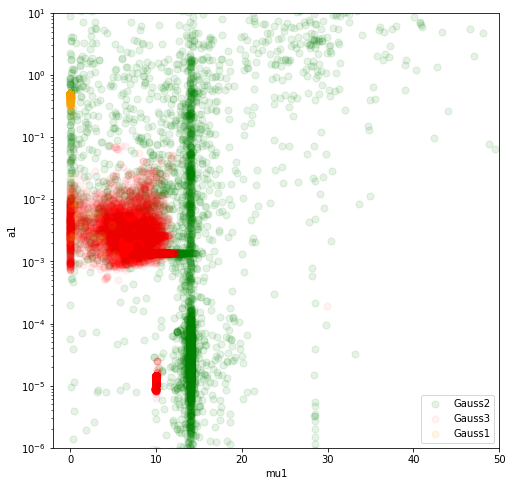

In [359]:
f  = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1= f.add_subplot(gs[0,0])

paramdf_3gauss_all.plot.scatter('mu2','a2',c='g',ax=ax1,label='Gauss2',s=50,alpha=.1)
paramdf_3gauss_all.plot.scatter('mu3','a3',c='r',ax=ax1,label='Gauss3',s=50,alpha=.05)
paramdf_3gauss_all.plot.scatter('mu1','a1',c='orange',ax=ax1,label='Gauss1',s=50,alpha=.1)
plt.yscale('log')
plt.ylim(1e-6,10)
plt.xlim(-2,50)
#plt.axhline(1e-2,0,20)
#plt.axvline(8,1e-4,1)
f.set_figheight(8)
f.set_figwidth(8)
plt.show()

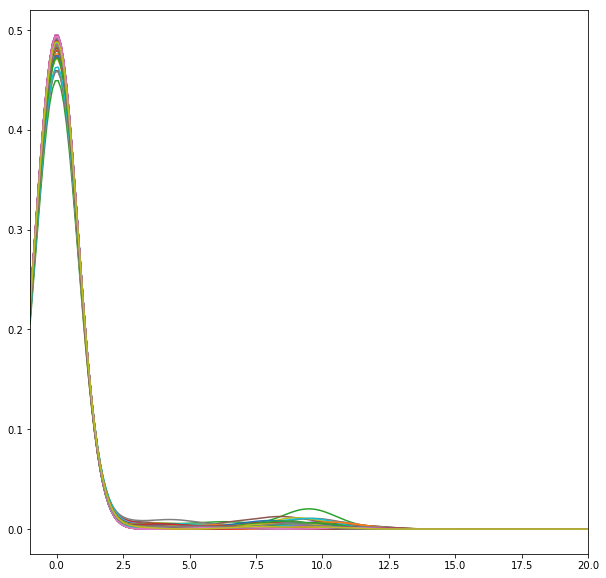

In [367]:
cols = paramdf_3gauss_all[paramdf_3gauss_all['mu2']>50].index
pdfall_df_skl[cols].plot(legend=False,figsize=(10,10))
plt.show()

In [362]:
pdfall_df_skl

,0610007P14Rik,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610037L13Rik,0610040J01Rik,...,mt-Ti,mt-Tl1,mt-Tl2,mt-Tm,mt-Tp,mt-Tq,mt-Tr,mt-Ts1,mt-Tv,mt-Ty
-1.000000,2.258297e-01,2.264501e-01,2.265097e-01,2.252169e-01,2.270705e-01,2.234077e-01,2.276909e-01,2.264574e-01,2.239685e-01,2.277505e-01,...,2.140549e-01,2.098331e-01,2.123911e-01,1.857270e-01,2.162463e-01,1.720600e-01,2.248939e-01,2.220895e-01,2.214181e-01,2.277505e-01
-0.894472,2.640050e-01,2.647303e-01,2.648124e-01,2.632913e-01,2.654556e-01,2.611861e-01,2.661809e-01,2.647414e-01,2.618292e-01,2.662630e-01,...,2.503788e-01,2.454684e-01,2.484773e-01,2.173113e-01,2.530054e-01,2.013359e-01,2.629760e-01,2.597599e-01,2.589656e-01,2.662630e-01
-0.788945,3.033098e-01,3.041431e-01,3.042543e-01,3.024939e-01,3.049764e-01,3.000882e-01,3.058096e-01,3.041597e-01,3.008100e-01,3.059208e-01,...,2.878457e-01,2.822381e-01,2.857210e-01,2.499235e-01,2.909495e-01,2.315743e-01,3.022159e-01,2.986056e-01,2.976808e-01,3.059208e-01
-0.683417,3.424554e-01,3.433962e-01,3.435443e-01,3.415401e-01,3.443370e-01,3.388406e-01,3.452778e-01,3.434205e-01,3.396330e-01,3.454259e-01,...,3.252531e-01,3.189665e-01,3.229349e-01,2.825303e-01,3.288696e-01,2.618220e-01,3.413384e-01,3.373747e-01,3.363150e-01,3.454259e-01
-0.577889,3.799835e-01,3.810275e-01,3.812212e-01,3.789766e-01,3.820714e-01,3.760022e-01,3.831153e-01,3.810625e-01,3.768519e-01,3.833090e-01,...,3.612387e-01,3.543212e-01,3.587735e-01,3.139608e-01,3.653946e-01,2.909991e-01,3.788995e-01,3.746486e-01,3.734536e-01,3.833090e-01
-0.472362,4.143514e-01,4.154897e-01,4.157388e-01,4.132657e-01,4.166280e-01,4.100482e-01,4.177663e-01,4.155393e-01,4.109365e-01,4.180155e-01,...,3.943596e-01,3.868902e-01,3.918109e-01,3.429743e-01,3.990699e-01,3.179623e-01,4.133700e-01,4.089241e-01,4.075977e-01,4.180155e-01
-0.366834,4.440337e-01,4.452536e-01,4.455685e-01,4.428877e-01,4.464735e-01,4.394708e-01,4.476933e-01,4.453227e-01,4.403743e-01,4.480082e-01,...,4.231881e-01,4.152755e-01,4.206357e-01,3.683432e-01,4.284536e-01,3.415814e-01,4.432373e-01,4.387121e-01,4.372635e-01,4.480082e-01
-0.261307,4.676343e-01,4.689190e-01,4.693101e-01,4.664515e-01,4.702037e-01,4.628892e-01,4.714884e-01,4.690135e-01,4.637805e-01,4.718795e-01,...,4.464151e-01,4.381942e-01,4.439526e-01,3.889421e-01,4.522199e-01,3.608217e-01,4.671145e-01,4.626460e-01,4.610897e-01,4.718795e-01
-0.155779,4.839941e-01,4.853237e-01,4.858010e-01,4.828026e-01,4.866533e-01,4.791571e-01,4.879830e-01,4.854507e-01,4.800056e-01,4.884602e-01,...,4.629516e-01,4.545773e-01,4.606824e-01,4.038347e-01,4.692605e-01,3.748244e-01,4.838479e-01,4.795859e-01,4.779419e-01,4.884602e-01
-0.050251,4.922853e-01,4.936377e-01,4.942103e-01,4.911173e-01,4.949902e-01,4.874549e-01,4.963426e-01,4.938055e-01,4.882289e-01,4.969150e-01,...,4.720162e-01,4.636553e-01,4.700486e-01,4.123493e-01,4.787731e-01,3.829763e-01,4.926104e-01,4.887104e-01,4.870041e-01,4.969150e-01
